In [1]:
import igraph as ig

IGRAPH UNW- 6 7 -- 
+ attr: label (v), name (v), weight (e)


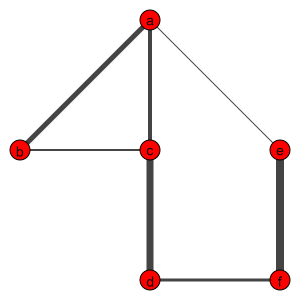

In [146]:
edgelist = [(0,1),(0,2),(0,4),(1,2),(2,3),(3,5),(4,5)]
#edgelist = [(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5),(4,6),(5,6),(6,7),(7,8),(7,9),(8,9)]
g = ig.Graph(edgelist)
g.vs["name"] = ["a", "b", "c", "d", "e", "f"]
#g.vs["name"] = ["a", "b", "c", "d", "e", "f","g", "h", "i", "j"]
g.vs["label"] = g.vs["name"]
g.es['weight'] = [5, 4, 1, 2, 7, 3, 8]
#g.es['weight'] = [5,5,5,1,5,5,5,5,5,1,5,5,5]
print(g.summary())
ig.plot(g, layout = g.layout("rt"), bbox=(300,300), edge_width = g.es['weight'])
#ig.plot(g, layout = g.layout("rt"), bbox=(300,300), edge_label=g.es["name"])

In [3]:
def init_commts(graph):
    counter_commts = 0
    graph.vs["commty"] = -1
    for node in graph.vs():
        node["commty"] = counter_commts
        counter_commts += 1


def get_neighbors_commts(node):
    """Extrae las comunidades vécinas"""
    comms_vecinas = [node["commty"]]
    vecinos_nodo = node.neighbors()
    for vecino in vecinos_nodo:
        if vecino["commty"] not in comms_vecinas:
            comms_vecinas.append(vecino["commty"])
    return comms_vecinas

def get_sum_in(graph, id_commty):
    """Obtine el valor sum_in de una comunidad"""
    # Obtener todos los nodos de la comunidad
    nodos_commty = graph.vs.select(commty=id_commty)
    comunidad = graph.subgraph(nodos_commty)
    return sum(comunidad.es["weight"])
    
def get_k_i_in(graph, node, id_commty):
    """Obtiene el valor de k_i_in."""
    nodos_commty = list(graph.vs.select(commty=id_commty))
    nodos_vecinos = node.neighbors()
    inters = set(nodos_vecinos).intersection(set(nodos_commty))
    sum_kiin = 0
    #print(nodos_commty, nodos_vecinos)
    for i in inters:
        i_edge = graph.get_eid(node, i)
        sum_kiin += graph.es(i_edge)["weight"][0]
    return sum_kiin

def get_sum_tot(graph, id_commty):
    """Obtine el valor de sum_total"""
    nodos_commty = list(graph.vs.select(commty=id_commty))
    all_incident_edges = []
    for node in nodos_commty:
        all_incident_edges = all_incident_edges + graph.incident(node)
    #print(all_incident_edges)
    sum_tota = 0
    for edge_ in all_incident_edges:
        sum_tota += graph.es(edge_)["weight"][0]

    return sum_tota

def get_k_i(graph, node):
    """Obtiene el k_i"""
    aristas_incidentes = graph.incident(node)

    sum_ki = 0
    for edge_ in aristas_incidentes:
        sum_ki += graph.es(edge_)["weight"][0]
    return sum_ki

def calculate_modularity(graph, m):
    suma_total = 0
    for i in set(list(graph.vs["commty"])):
        #print(graph.vs.select(commty=i)["name"])
        nodes_in_commty = graph.vs.select(commty=i)    
        for node_i in nodes_in_commty:
            for node_j in nodes_in_commty:
                if node_i != node_j:                
                    #print(node_i["name"], node_j["name"])
                    try:
                        edge_i = graph.get_eid(node_i.index, node_j.index)
                        edge_i = graph.es(edge_i)["weight"][0]
                        suma_temp = edge_i - (get_k_i(graph, node_i)*get_k_i(graph, node_j)) / (2*m)
                        suma_total += suma_temp
                    except:
                        continue
    return suma_total/(2*m)

In [147]:

finished = False
m = sum(g.es["weight"])
counter_iteration = 1
init_commts(g) # Inicializar comunidaes
new_modularity = -1
new_partition = g.vs["commty"]
while not finished:        
    nodes = g.vs()
    finished = True
    print("#####*****",counter_iteration, "Iteration #####*****")
    print(list(g.vs()["name"]))
    print([str(i) for i in list(g.vs["commty"])])
    counter_iteration += 1
    prev_modularity = new_modularity    
    prev_partition = list(g.vs["commty"])

    for node in nodes:
        print("Posición de nodo:", node["name"])
        
        neigh_commts = get_neighbors_commts(node)
        print(neigh_commts)
        dict_commts = {} # {id_comty: Q}

        for commty_neigh in neigh_commts: # Por cada comunidad vécina
            #print(get_sum_in(g, commty_neigh))
            #print(get_k_i_in(g, node, commty_neigh))
            #print(get_sum_tot(g, commty_neigh))
            #print(get_k_i(g, node))

            # Calculo de modularidad
            sum_in = get_sum_in(g, commty_neigh)
            k_i_in = get_k_i_in(g, node, commty_neigh)
            sum_tot = get_sum_tot(g, commty_neigh)
            k_i = get_k_i(g, node)

            first_q = k_i_in / (2*m)
            secon_q = (sum_tot*k_i) /  (2*pow(m,2))
            q = first_q - secon_q
            dict_commts[commty_neigh] = q
            print(commty_neigh,q)
        max_id_commty = max(dict_commts, key=dict_commts.get)
        if max_id_commty != node["commty"]: # Cambia de comunidad
            if finished:
                finished = False                        
            print("Node", node["name"], "se va a commty", max_id_commty)            
            node["commty"] = max_id_commty
        else:
            print("Sin cambios")
    #new_modularity = calculate_modularity(g, m)
    partition = ig.VertexClustering.FromAttribute(g, "commty")
    new_modularity = partition.modularity
    new_partition = list(g.vs["commty"])
    print()
    print("NUeva Propuesta")
    print(list(g.vs()["name"]))
    print([str(i) for i in list(g.vs["commty"])])    
    print()
    print("* ", prev_partition, prev_modularity)
    if prev_modularity > new_modularity:        
        g.vs["commty"] = prev_partition
        finished = True
    print(new_modularity)

    print()

print("***********************************")    
print(list(g.vs()["name"]))
print([str(i) for i in list(g.vs["commty"])])    


    

#####***** 1 Iteration #####*****
['a', 'b', 'c', 'd', 'e', 'f']
['0', '1', '2', '3', '4', '5']
Posición de nodo: a
[0, 1, 2, 4]
0 -0.05555555555555555
1 0.04444444444444444
2 -0.00555555555555555
4 -0.03333333333333334
Node a se va a commty 1
Posición de nodo: b
[1, 2]
1 0.017222222222222222
2 -0.017222222222222222
Sin cambios
Posición de nodo: c
[2, 1, 3]
2 -0.09388888888888888
1 -0.022777777777777772
3 0.04444444444444445
Node c se va a commty 3
Posición de nodo: d
[3, 5]
3 -0.0111111111111111
5 -0.011111111111111106
Sin cambios
Posición de nodo: e
[4, 1, 5]
4 -0.045
1 -0.06833333333333334
5 0.07833333333333334
Node e se va a commty 5
Posición de nodo: f
[5, 3]
5 0.011111111111111113
3 -0.09055555555555554
Sin cambios

NUeva Propuesta
['a', 'b', 'c', 'd', 'e', 'f']
['1', '1', '3', '3', '5', '5']

*  [0, 1, 2, 3, 4, 5] -1
0.09183673469387758

#####***** 2 Iteration #####*****
['a', 'b', 'c', 'd', 'e', 'f']
['1', '1', '3', '3', '5', '5']
Posición de nodo: a
[1, 3, 5]
1 -0.011111111111

IGRAPH UNW- 2 3 -- 
+ attr: label (v), name (v), weight (e)


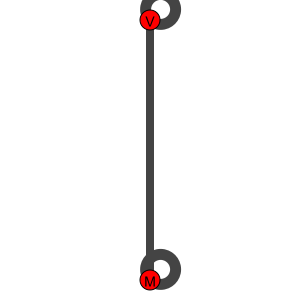

In [148]:
edgelist = [(0,0),(0,1),(1,1)]
#edgelist = [(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5),(4,6),(5,6),(6,7),(7,8),(7,9),(8,9)]
g = ig.Graph(edgelist)
g.vs["name"] = ["V", "M"]
#g.vs["name"] = ["a", "b", "c", "d", "e", "f","g", "h", "i", "j"]
g.vs["label"] = g.vs["name"]
g.es['weight'] = [11, 8, 11]
#g.es['weight'] = [5,5,5,1,5,5,5,5,5,1,5,5,5]
print(g.summary())
ig.plot(g, layout = g.layout("rt"), bbox=(300,300), edge_width = g.es['weight'])
#ig.plot(g, layout = g.layout("rt"), bbox=(300,300), edge_label=g.es["name"])

In [149]:

finished = False
m = sum(g.es["weight"])
counter_iteration = 1
init_commts(g) # Inicializar comunidaes
new_modularity = -1
new_partition = g.vs["commty"]
while not finished:        
    nodes = g.vs()
    finished = True
    print("#####*****",counter_iteration, "Iteration #####*****")
    print(list(g.vs()["name"]))
    print([str(i) for i in list(g.vs["commty"])])
    counter_iteration += 1
    prev_modularity = new_modularity    
    prev_partition = list(g.vs["commty"])

    for node in nodes:
        print("Posición de nodo:", node["name"])
        
        neigh_commts = get_neighbors_commts(node)
        print(neigh_commts)
        dict_commts = {} # {id_comty: Q}

        for commty_neigh in neigh_commts: # Por cada comunidad vécina
            #print(get_sum_in(g, commty_neigh))
            #print(get_k_i_in(g, node, commty_neigh))
            #print(get_sum_tot(g, commty_neigh))
            #print(get_k_i(g, node))

            # Calculo de modularidad
            sum_in = get_sum_in(g, commty_neigh)
            k_i_in = get_k_i_in(g, node, commty_neigh)
            sum_tot = get_sum_tot(g, commty_neigh)
            k_i = get_k_i(g, node)

            first_q = k_i_in / (2*m)
            secon_q = (sum_tot*k_i) /  (2*pow(m,2))
            q = first_q - secon_q
            dict_commts[commty_neigh] = q
            print(commty_neigh,q)
        max_id_commty = max(dict_commts, key=dict_commts.get)
        if max_id_commty != node["commty"]: # Cambia de comunidad
            if finished:
                finished = False                        
            print("Node", node["name"], "se va a commty", max_id_commty)            
            node["commty"] = max_id_commty
        else:
            print("Sin cambios")
    #new_modularity = calculate_modularity(g, m)
    partition = ig.VertexClustering.FromAttribute(g, "commty")
    new_modularity = partition.modularity
    new_partition = list(g.vs["commty"])
    print()
    print("NUeva Propuesta")
    print(list(g.vs()["name"]))
    print([str(i) for i in list(g.vs["commty"])])    
    print()
    print("* ", prev_partition, prev_modularity)
    if prev_modularity > new_modularity:        
        g.vs["commty"] = prev_partition
        finished = True
    print(new_modularity)

    print()

print("***********************************")    
print(list(g.vs()["name"]))
print([str(i) for i in list(g.vs["commty"])])    


    

#####***** 1 Iteration #####*****
['V', 'M']
['0', '1']
Posición de nodo: V
[0, 1]
0 -0.31666666666666665
1 -0.3666666666666667
Sin cambios
Posición de nodo: M
[1, 0]
1 -0.31666666666666665
0 -0.3666666666666667
Sin cambios

NUeva Propuesta
['V', 'M']
['0', '1']

*  [0, 1] -1
0.16666666666666663

***********************************
['V', 'M']
['0', '1']
